# Web Crawler

Collect text data from the PTT forum, process the article texts, and finally create a word cloud for a quick overview of the topics in these collected texts.

## Crawling Data from PTT

In [1]:
import requests
from bs4 import BeautifulSoup as soup  # HTML data structure
from lxml import etree


# extract article hyperlinks from an index page
def extractArtLinks(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    containers = page_soup.findAll("div", {"class": "r-ent"})
    art_links = []
    for container in containers:
        # Finds all link tags "a" from within the first div.
        art_link = container.find('a')
        if art_link:
            #print(art_link['href'])
            #print(container.find('div',{'class':'title'}).get_text())
            art_meta = container.find('div', {'class': 'meta'})
            #print(art_meta.find('div',{'class':'author'}).get_text())
            #print(art_meta.find('div',{'class':'date'}).get_text())

            art_links.append({
                'push':
                container.find('div', {
                    'class': 'nrec'
                }).get_text(),
                'title':
                container.find('div', {
                    'class': 'title'
                }).get_text().strip(),
                'date':
                art_meta.find('div', {
                    'class': 'date'
                }).get_text(),
                'author':
                art_meta.find('div', {
                    'class': 'author'
                }).get_text(),
                'link':
                art_link['href'],
                'text':
                extractArtText('https://www.ptt.cc' + art_link['href'])
            })

    return (art_links)


# find the previous index page link
def findPrevIndex(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    btn = page_soup.select('div.btn-group > a')
    up_page_href = btn[3]['href']
    next_page_url = 'https://www.ptt.cc' + up_page_href
    return (next_page_url)


# extract article contents from  the article hyperlink
def extractArtText(url):
    r = requests.get(url, cookies={'over18': '1'})
    #page_soup = soup(r.text, "lxml")
    #print(page_soup.find("div",{"id":"main-content"}).get_text())
    #art_text=page_soup.select('div#main-content', limit=1)[0].text
    content = r.content.decode()
    html = etree.HTML(content)
    art_text = html.xpath(
        "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]"
    )
    return ''.join(list(art_text))

In [2]:
## Debug Use

# url = 'https://www.ptt.cc/bbs/Food/M.1602332821.A.6F3.html'
# r = requests.get(url, cookies={'over18': '1'})
# #page_soup = soup(r.text, "lxml")
# #print(page_soup.find("div",{"id":"main-content"}).get_text())
# #art_text=page_soup.select('div#main-content', limit=1)[0].text
# content = r.content.decode()
# html = etree.HTML(content)
# art_text = html.xpath(
#     "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]")

# print(''.join(list(art_text)))

```{note}
For CSS selector, don't know how to set conditional criteria to select only texts under div#main-container but not those included in the child div.article-metaline and span.f2.

So here I use the XPath, which requires the lxml package.
```

In [3]:
# main()
num_of_index_page = 5
board_name = 'Food'
url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board_name)
all_links = []
for page in range(1, num_of_index_page):
    all_links = all_links + extractArtLinks(url)
    url = findPrevIndex(url)
len(all_links)

75

In [4]:
type(all_links[2])
print(all_links[2])

{'push': '', 'title': '[食記] 宜蘭 地熱小姐', 'date': '11/06', 'author': 'osakaleo', 'link': '/bbs/Food/M.1604675140.A.F5B.html', 'text': '\n   餐廳名稱：地熱小姐\n   消費時間：2020年9月\n   地址：宜蘭縣蘇澳鎮學府路75號\n   電話：0928 281 470\n\n\n有圖有真相網誌版：\n\n\n聽朋友說南方澳有一家蛋糕店「地熱小姐」很有名。\n我們就來報到了！\n\n我們買了柚檸香橙蛋糕。\n\n跟大家報告，好好吃啊！！！\n\n蛋糕體本身就很好吃，\n加上鮮奶油及上面的水果(柳丁和葡萄柚)搭配得恰到好處！\n真的是非常好吃的一款蛋糕！\n\n喜歡吃蛋糕的同學，不要錯過「地熱小姐」喔！\n\n對了，店名叫「地熱小姐」，\n因為dessert發音近中文「地熱」的啦！\n本來還想說南方澳有地熱嗎？\n怎麼取這個名字！XD\n\n\n--\n'}


In [5]:
print('Push: {push:s} \n'
      'title: {title:s} \n'
      'date: {date:s} \n'
      'author: {author:s} \n'
      'link: {link:s} \n'
      'text: {text:.20} \n'.format(**all_links[3]))

Push:  
title: [食記] 台北信義林口街 榕樹下無名清蒸肉圓(油飯 
date: 11/06 
author: TW00500203 
link: /bbs/Food/M.1604675717.A.183.html 
text: 
電話：02 2726 2900
地址： 



## Text Normalization

In [6]:
import sys
sys.path.insert(1, '../nlp')
import text_normalizer_zh as tn

In [7]:
print(all_links[3]['text'])


電話：02 2726 2900
地址：台北市信義區林口街79號
營業時間：15:00-22:00 (賣完為止)
消費時間：2020年11月
每人平均價位：35~95
服務費：無
外送：無
其他支付：無
----------------------------

圖文網誌好讀版本:

----------------------------
今天又要來個從小吃到大系列的復古路線，這一家林口街上的無名肉圓，我大概吃了十年
以上有吧，太久了已不可考，從漲價前一份25元到漲價至30後至少8年以上，一路的吃吃
吃吃吃到現在。




常常想跟朋友推薦這家好吃的清蒸肉圓，因為無名始終不知道要怎樣介紹，只能說就是林
口街公園旁有個宮的肉圓拉，旁邊還有顆大榕樹(?)，真符合「路邊一顆榕樹下是我懷念
的地方」這樣的感覺，這家的肉圓的確就是我懷念的好滋味。

品項簡單只賣肉圓、四神湯、油飯、淡水魚丸湯，每一樣都35以內，這價位看了一下應該
8年多沒漲的樣子，真是佛心阿！




除了前場攤子前的位置，萬應宮這也有位置可以坐。




今天一個人就把除了淡水魚丸湯以外的產品給功略掉吧！


【四神湯 NT.35】
這家很好玩的特色是湯比主食貴，四神湯裡料不少，小腸處理得很棒沒有腥味，ＱＱ的嚼
起來蠻香，湯頭則是帶有藥酒香，喝起來蠻香的，35元我是覺得CP值蠻高的，雖然我更喜
歡景美雙管四神湯，但這邊的四神湯我覺得也不錯。


【油飯 NT.30】
油飯可能是我在這間小店比較少點的項目，不是他不好吃，是我大多是想吃點點心嘴饞時
候來，如果吃了肉圓加油飯就會比較飽，這次來吃晚餐就可以多點一些。

這碗其實不大，裡頭的油飯我是蠻大推的，吃起來油蔥的香味濃，帶點醬油的濃醇香氣，
沒有薑味，單吃就很有味道，口感非常的Q，配上點香菜轉換口味，雖然少吃但我也是還
蠻喜歡的。



一旁有兩種醬甜辣醬還有辣椒醬，不過我自己是都不太愛加，原味就很好吃了，而且我比
較不喜歡他們的甜辣醬，有點微微的辣椒酸感，不夠甜，辣椒醬也是偏鹹，我建議來吃原
味就好，不然一定要加一旁一點點先嘗看看再說。







【肉圓 NT.30】
像這種一份兩顆30元的清蒸肉圓哪裡還有呢？這一份肉圓從我去台南前吃到我回來台北，
就是喜歡這一味，他的皮非常軟嫩，但仍保有米皮的口感，不會爛成一團，內餡則是有嚼
勁的豬腿肉，有肥有瘦，

In [8]:
raw = [art['text'] for art in all_links if len(art) != 0 and len is not None]
raw_normalized = tn.normalize_corpus(raw)

Building prefix dict from /Users/Alvin/GoogleDrive/_MySyncDrive/RepositoryData/data/jiaba/dict.txt.jiebatw.txt ...


Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.u1b52b47246a0f2e6497af6bbe107adac.cache


Loading model cost 0.551 seconds.


Prefix dict has been built successfully.


In [9]:
import pandas as pd

corpus_df = pd.DataFrame({"raw": raw, "normalized": raw_normalized})

In [10]:
corpus_df.head(2)

,raw,normalized
0,\n 餐廳名稱：阿倫冰店 潮州燒冷冰\n 消費時間：2020年10月\n 地址：...,餐廳 名稱 阿倫 冰店 潮州 燒冷冰 消費 時間 年 月 地址 屏東縣 潮州鎮 新生路 號 ...
1,\n\n\n\n\n\n\n圖文：(2020年11月)\n\n\n\n\n\n-------...,圖文 年 月 南勢角 厚切 牛肉麵 地址 新 北市 中和 區興南路 二段 巷 號 時間 電話...


In [11]:
raw[5]

'\n   餐廳名稱：元生牛肉麵\n   消費時間：2020年/11月\n   地址：桃園市中壢區文化路277號\n   電話：03-4517585\n   營業時間：11:00-20:30\n\n圖文版：\n\n\n\n    內壢美食推文探險，第七站是文化路與元生三街口的元生牛肉\n麵。\n\n    這裡的麵食種類不少，櫃檯也有滷味可選，旁邊貼有價目表。\n內用一百元以上可享用免費豆花，由客人自行於冰櫃舀盛，再加入\n糖水。\n\n招牌三寶麵 180元  海帶 10元  甜不辣 10元  豬頭皮 50元\n\n\n\n    麵條為細圓麵，無咬勁。湯頭溫和，無預期紅燒的厚重鹹香。\n牛筋軟中帶Ｑ；牛肉硬韌略難咬；牛肚彈而無臊。整碗麵亮眼處大\n概是牛筋個頭不小。酸菜味淡，加與不加差別有限。\n\n\n\n    滷味上桌前會汆燙過，然而通通無味而純靠偏甜油膏相佐。調\n味檯上的辣椒重辣少油香，辣椒蔥花醬油的提味較好。\n\n\n\n\u3000\u3000這天最棒的餐點是免費豆花，綿密軟實有豆香。糖水雖然沒有\n香氣，但甜度舒服。\n\n\u3000\u3000原來還抄得清燉羊肉麵推薦，只是除豆花外實在與個人喜好有\n別，留待大家自行感受。\n\n\n--\n      上弦月天邊眺望           黃嘴角鴞林間低唱\n\n      嫣紅野櫻沿路綻放         潺潺流水山谷空響\n\n      怡然桶後林道旁           沈醉其芳\n\n--\n'

In [12]:
raw_normalized[4]

'餐廳 名稱 威爾森 龍蝦 愛爾蘭 瘋薯 消費 時間 年 月 地址 台北市 信義區 松壽路 號 電話 營業 時間 不想 花個 幾千塊 吃 龍蝦 大餐 又 想 品嚐 一下 龍蝦 的 風味 點個 龍蝦 堡 是 個 不錯 的 選擇 今天 來試 的 是 威爾森 龍蝦 愛爾蘭 瘋薯 的 龍蝦 堡 餐廳 就 位於 信義區 華內 威秀 跟 微風 南山 旁邊 據說 他們 的 主廚 劉 承恩 師從 紐約 米 其 林 星 餐廳 主廚 學習 法式 料理 回國 後 曾 在 寒舍 艾美 酒店 等 大 飯店 工作 威爾森 龍蝦 愛爾蘭 瘋薯 戶外區 有十幾個 座位 走 的 是 美式 風格 現在 是 中午 時分 較 沒人 晚上 人會 比較 多 連 布置 都 很 龍蝦 櫃檯 上方 有 價目表 龍蝦 堡 一個 元 有 種 口味 雙倍 龍蝦肉 則是 元 也 有 干貝 堡 可以 選 略為 便宜 一些 為 元 打卡 按讚 有 優惠 紙本 龍蝦 堡 菜單 龍蝦 跟 干貝 也 是 可以 混搭 的 價格 是 因為 喜歡 美乃滋 這次 我 吃 的 是 紐約 風味 龍蝦 堡 外帶 的 紐約 風味 龍蝦 堡 裝在 紙盒 裡 還 附上 透明 塑膠 蓋 紐約 風味 龍蝦 堡 夾著 一大片 蔬菜 淋上 大量 美乃滋 跟 特製 酸醬 略帶 酸甜 算是 比較 重 口味 的 龍蝦 堡 麵包 烤 得 滿 酥軟 的 可以 吃到 大 塊 波士頓 龍蝦肉 龍蝦肉 緊實 不柴 有 彈性 整體 來 說 中規中矩 下次 有 機會 再 試試 其 它 口味 龍蝦 堡 份量 並不是 很 大 很快 就 吃完 了 是 用完 餐才 過來 龍蝦 堡 對 我 來 說 比較 像 是 點心 的 概念 以堡 來 說 不 便宜 但是 以能 吃到 新鮮 龍蝦 的 思維 來 看 算是 可以 了'

- [Unicode List](https://en.wikipedia.org/wiki/List_of_Unicode_characters)
- [Unicode Categories](https://unicodebook.readthedocs.io/unicode.html)

In [13]:
text = raw[0]
text

'\n   餐廳名稱：阿倫冰店 潮州燒冷冰\n   消費時間：2020年10月\n   地址：屏東縣潮州鎮新生路149號\n   營業時間：9:00~22:50\n   電話：08-7892202\n\n圖文:\n\n來到屏東潮州玩耍，除了品嚐知名的潮州燒冷冰，\n還有圓環附近的新景點”潮州日式歷史建築文化園區”可以逛逛，\n潮州燒冷冰在這裡有兩家，一家是”阿倫冰店 潮州燒冷冰”，\n另一家是對面的”正老牌潮州冷熱冰”，來之前已經做了功課，\n得知兩家都很夯、各有支持者，但這天問了兩位在地的朋友及文化園區的導覽員，\n他們都比較推薦阿倫冰店，當天我們人還在逛文化園區，\n心裡卻是一直想趕快吃到超人氣的潮州燒冷冰~ 哈哈!\n\n阿倫冰店創立於民國54年，數十年的老店! 店址位於潮州圓環旁，\n整片藍色的招牌很好認!\n\n隔著馬路，對面就是另一家知名的正老牌潮州冷熱冰~\n當天即使下著大雨，依然不減店內超夯的人氣~ 客人來來去去，一下子又坐滿了~\n店內貼著許多藝人來訪的照片，店員忙進忙出，客氣的問大家要點什麼~\n\n來這裡就趕緊看這塊牌子就對了! 綜合燒冷冰現在一碗漲到50元了!\n最早看有的網友從25元吃到45元，這天看到的目前是50元，不過也因為這老滋味太經典，\n依然人氣滿滿~  其中下方黃色的部份有提醒大家怎麼吃燒冷冰，最重要的…\n就是要先吃湯圓囉!\n\n桌子上放著綜合燒冷冰需要的用料~ 最讓我驚奇的是那整顆熬煮得軟綿的芋頭，\n看起來怎麼會這麼誘人啊~\n\n另一個有趣的是快速製作方形的湯圓，只見手指快速撥動麵團，\n就這樣一顆顆湯圓跳下鍋，實在太有趣了~\n\n綜合燒冷冰上桌! 好料都藏在冰底下囉!\n現場發現好多阿公阿嬤級的老饕，當天現場就有七、八位阿公阿嬤級的客人捏!\n挖開底下豐富的配料，除了在地的綠豆蒜，\n裡面還有大顆花生湯圓、小湯圓、土豆仁以及紅豆等，\n值得一提的是他們的糖水香濃美味，搭配起來真的很厲害!\n\n趁熱吃的花生湯圓，外冰內熱又軟Q，口感及味覺都有驚喜，厲害啊!\n小湯圓也很讚! 方正形狀的湯圓讓我想到北港圓仔湯的也是這樣，\n但我更愛這裡的Q軟口感，一吃上癮~\n\n再來是濃郁又綿密的芋頭也好吃! 這幾款用料搭起來可真是無敵，\n看似平凡卻又那麼的精彩! 也難怪每天都超人氣~\n\n忍不住大口咬芋頭，甜滋滋的芋頭搭配冰

In [14]:
import unicodedata

result = ''.join(ch for ch in text
                 if unicodedata.category(ch)[0] not in ['P', 'S'])
result

'\n   餐廳名稱阿倫冰店 潮州燒冷冰\n   消費時間2020年10月\n   地址屏東縣潮州鎮新生路149號\n   營業時間9002250\n   電話087892202\n\n圖文\n\n來到屏東潮州玩耍除了品嚐知名的潮州燒冷冰\n還有圓環附近的新景點潮州日式歷史建築文化園區可以逛逛\n潮州燒冷冰在這裡有兩家一家是阿倫冰店 潮州燒冷冰\n另一家是對面的正老牌潮州冷熱冰來之前已經做了功課\n得知兩家都很夯各有支持者但這天問了兩位在地的朋友及文化園區的導覽員\n他們都比較推薦阿倫冰店當天我們人還在逛文化園區\n心裡卻是一直想趕快吃到超人氣的潮州燒冷冰 哈哈\n\n阿倫冰店創立於民國54年數十年的老店 店址位於潮州圓環旁\n整片藍色的招牌很好認\n\n隔著馬路對面就是另一家知名的正老牌潮州冷熱冰\n當天即使下著大雨依然不減店內超夯的人氣 客人來來去去一下子又坐滿了\n店內貼著許多藝人來訪的照片店員忙進忙出客氣的問大家要點什麼\n\n來這裡就趕緊看這塊牌子就對了 綜合燒冷冰現在一碗漲到50元了\n最早看有的網友從25元吃到45元這天看到的目前是50元不過也因為這老滋味太經典\n依然人氣滿滿  其中下方黃色的部份有提醒大家怎麼吃燒冷冰最重要的\n就是要先吃湯圓囉\n\n桌子上放著綜合燒冷冰需要的用料 最讓我驚奇的是那整顆熬煮得軟綿的芋頭\n看起來怎麼會這麼誘人啊\n\n另一個有趣的是快速製作方形的湯圓只見手指快速撥動麵團\n就這樣一顆顆湯圓跳下鍋實在太有趣了\n\n綜合燒冷冰上桌 好料都藏在冰底下囉\n現場發現好多阿公阿嬤級的老饕當天現場就有七八位阿公阿嬤級的客人捏\n挖開底下豐富的配料除了在地的綠豆蒜\n裡面還有大顆花生湯圓小湯圓土豆仁以及紅豆等\n值得一提的是他們的糖水香濃美味搭配起來真的很厲害\n\n趁熱吃的花生湯圓外冰內熱又軟Q口感及味覺都有驚喜厲害啊\n小湯圓也很讚 方正形狀的湯圓讓我想到北港圓仔湯的也是這樣\n但我更愛這裡的Q軟口感一吃上癮\n\n再來是濃郁又綿密的芋頭也好吃 這幾款用料搭起來可真是無敵\n看似平凡卻又那麼的精彩 也難怪每天都超人氣\n\n忍不住大口咬芋頭甜滋滋的芋頭搭配冰涼的糖水真是過癮極了\n阿倫冰店果真沒讓大夥兒失望要不是午餐已經吃過當下還真的想要來上兩碗\n那豐富又經典的配料堪稱無敵啊 光是湯圓芋頭就讓我回味無窮\n推薦大家一定要

## Word Cloud

In [15]:
from collections import Counter
import imageio
from nltk.tokenize import WhitespaceTokenizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

In [16]:
## Check font paths
## !fc-list :lang=zh

ws = WhitespaceTokenizer()

tokens = [ws.tokenize(text) for text in raw_normalized]

In [17]:
from collections import Counter

# corpus token freq
tokens_freq = Counter(sum(tokens, []))
sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)

# corpus token freq per document
tokens_freq_per_doc = [Counter(wt) for wt in tokens]

# corpus token docfreq
tokens_df = Counter()

# map(tokens_df.update, (tfpd.keys() for tfpd in tokens_freq_per_doc))

for tfpd in tokens_freq_per_doc:
    tokens_df.update(tfpd.keys())

print(tokens_df)

Counter({'的': 75, '時間': 73, '有': 72, '是': 68, '了': 66, '餐廳': 65, '號': 65, '在': 65, '消費': 64, '地址': 64, '也': 64, '電話': 63, '營業': 62, '都': 62, '名稱': 60, '很': 60, '就': 57, '人': 57, '吃': 56, '不': 56, '可以': 54, '會': 54, '年': 53, '月': 52, '我': 52, '來': 49, '圖文': 48, '但': 48, '好吃': 47, '跟': 46, '價位': 46, '好': 44, '版': 44, '每人': 43, '到': 42, '比較': 41, '推薦': 41, '上': 41, '說': 41, '覺得': 41, '不過': 40, '要': 40, '不錯': 40, '沒有': 39, '想': 37, '就是': 37, '平均': 37, '菜單': 37, '無': 36, '喜歡': 36, '味道': 36, '元': 35, '因為': 35, '讓': 35, '口感': 35, '再': 35, '我們': 34, '多': 34, '去': 34, '又': 33, '得': 33, '還': 33, '看': 32, '真的': 32, '與': 32, '網誌': 32, '大': 32, '口味': 32, '菜色': 32, '小': 31, '和': 31, '他': 31, '店家': 31, '後': 30, '這': 30, '其': 30, '用餐': 29, '餐點': 29, '有無': 29, '沒': 28, '雖然': 28, '還是': 28, '一': 28, '包廂': 28, '所以': 28, '還有': 27, '朋友': 27, '可': 27, '其實': 27, '個': 27, '時': 27, '不會': 27, '特別': 27, '以': 27, '等': 26, '一點': 26, '非常': 26, '如果': 26, '才': 26, '可否': 26, '刷卡': 26, '店': 25, '這個': 25, '感覺': 25, '吃起來'

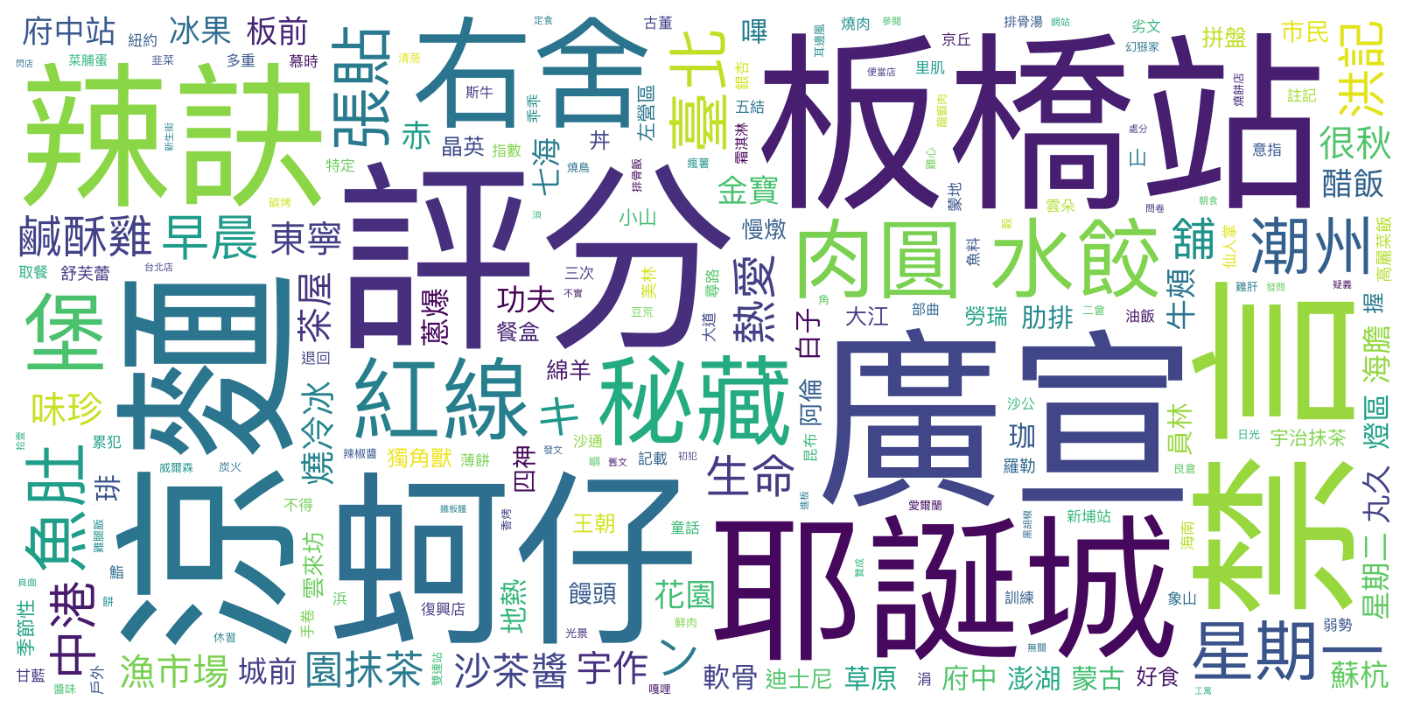

In [18]:
## Load stopwords
with open(
        '../../../RepositoryData/data/stopwords/tomlinNTUB-chinese-stopwords.txt'
) as f:
    stopwords = [w.strip() for w in f.readlines()]

# Create stopwords ad hoc
stopwords = set([
    '文章', '食記', '水桶', '刪除', '投票', '刪文', '連結', '板面', '板主', '規定', '違規', '使用',
    '所以', '禁止', '天', '票'
])

# Cutoff based on docfreq and stopwords
words2plot = dict([(w, tokens_freq[w]) for w, df in tokens_df.items()
                   if df < 2 and w not in stopwords and tokens_freq[w] >= 2])

wordcloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",
                      background_color='white',
                      stopwords=stopwords,
                      width=1600,
                      height=800,
                      margin=20)
# wordcloud.generate(' '.join([w for w in tokens_unnest if w not in stopwords]))
wordcloud.generate_from_frequencies(words2plot)
plt.figure(figsize=(20, 10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../data/twp-wordcloud2.png', facecolor='k', bbox_inches='tight')

:::{admonition} Exercise
How to seperate post texts from push texts?
:::
